In [7]:
import numpy as np
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from utils.common import save_tab, load_tab
from params import *

# Create a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(19680801)

In [ ]:
# path
ROOT = os.path.abspath('..')
path_domain_linker = os.path.join(ROOT, 'domain_linker/origin_dsAll')

path_drop = os.path.join(path_domain_linker, 'DROP_LinkerList.txt')

# Comparing 2 versions of DS-All datasets

DS-All: is the original version of DS-All dataset\
DROP: the slightly modified DS-All dataset was been used for DROP (a domian linker predictor).

## Loading

In [3]:
df_drop = pd.read_csv(path_drop, sep='\t')
df_dsAll = pd.read_csv(path_dsAll, sep='\t')

In [4]:
len(df_dsAll['PDBID'].unique())

206

In [5]:
df_dsAll

,PDBID,LinkerPosition
0,1a0p,89-114
1,1a2v_A,110-117 & 232-242
2,1a6c_A,164-178
3,1a6q,291-298
4,1au7_A,74-109
...,...,...
201,2pia,99-112 & 224-237
202,2sli,272-290
203,3pro_D,84-87
204,4crx_A,127-138


## DROP

DS-All dataset from DROP predictor: https://paperpile.com/shared/bg48a6

In [66]:
# split PDBID into: pdbid, chainID, is multidomain or not
pdbid_split = np.array([x.split('_')+[1] if '_' in x else x.split('|')+[0] for x in df_drop['PDBID']])
# multi_domain: 1 - yes, 0 - no.
df_drop[['PDBID', 'chain', 'multi_chain']] = pdbid_split
# trans str to int
df_drop['multi_chain'] = [int(x) for x in df_drop['multi_chain']]

In [67]:
df_drop[df_drop['PDBID']=='1rtm']

,PDBID,START,END,chain,multi_chain
168,1rtm,31,38,1,1


In [68]:
# 'chain' of the protein sequences with only one chain is the first number of 'START'
df_drop

,PDBID,START,END,chain,multi_chain
0,1a2v,215,225,A,1
1,1a2v,93,100,A,1
2,1a6c,164,178,A,1
3,1a6q,291,298,2,0
4,1b8a,100,116,A,1
...,...,...,...,...,...
207,2pia,99,112,9,0
208,2sli,192,210,1,0
209,3pro,84,87,D,1
210,4crx,108,119,A,1


In [69]:
# set proteins with only one chain, 'chain' column to zero
# df_drop['chain'] = ['0' if re.search(r'[0-9]', x) else x for x, y in df_drop['chain']]
df_drop['chain'] = ['0' if y==0 else x for x, y in zip(df_drop['chain'], df_drop['multi_chain'])]

**Linker length**

In [70]:
# calculate linker length
df_drop['LENGTH'] = df_drop['END'] - df_drop['START'] + 1
df_drop = df_drop.sort_values(by=['PDBID', 'START']).reset_index(drop=True)

## DS-All

DS-All dataset from original paper:
https://paperpile.com/shared/VOhRRB

In [4]:
# split PDBID into: pdbid, chainID, is multidomain or not
pdbid_split = np.array([x.split('_')+[1] if '_' in x else [x, 0, 0] for x in df_dsAll['PDBID']])
# multi_domain: 1 - yes, 0 - no.
df_dsAll[['PDBID', 'chain', 'multi_chain']] = pdbid_split
# trans str to int
df_dsAll['multi_chain'] = [int(x) for x in df_dsAll['multi_chain']]

In [7]:
df_dsAll[:5]

,PDBID,LinkerPosition,chain,multi_chain
0,1a0p,89-114,0,0
1,1a2v,110-117 & 232-242,A,1
2,1a6c,164-178,A,1
3,1a6q,291-298,0,0
4,1au7,74-109,A,1


In [5]:
# split LinkerPosition into start & end columns
dict_dsAll = {'PDBID': [], 'START': [], 'END': [], 'chain': [], 'multi_chain':[]}
for index, row in df_dsAll.iterrows():
    linker_position = row['LinkerPosition']
    for lp in linker_position.split('&'):
        dict_dsAll['PDBID'] += [row['PDBID']]
        dict_dsAll['START'] += [int(lp.split('-')[0])]
        dict_dsAll['END'] += [int(lp.split('-')[1])]
        dict_dsAll['chain'] += [row['chain']]
        dict_dsAll['multi_chain'] += [row['multi_chain']]

df_dsAll = pd.DataFrame(dict_dsAll).sort_values(by=['PDBID', 'START'])

In [6]:
len(df_dsAll['PDBID'].unique())

206

**Linker length**

In [7]:
# calculate linker length
df_dsAll['length'] = df_dsAll['END'] - df_dsAll['START'] + 1
df_dsAll = df_dsAll.sort_values(by=['PDBID', 'START'])

In [8]:
sum(df_dsAll['length']<15), sum(df_dsAll['length']<20), sum(df_dsAll['length']<25), sum(df_dsAll['length']<35), sum(df_dsAll['length']<50)

(180, 212, 222, 234, 242)

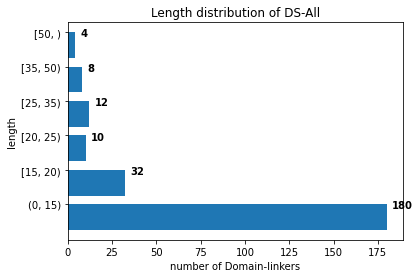

In [9]:
import matplotlib.pyplot as plt

x = [u'(0, 15)', u'[15, 20)', u'[20, 25)', u'[25, 35)', u'[35, 50)', u'[50, )']
y = [180, 32, 10, 12, 8, 4]

fig, ax = plt.subplots()  
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), fontweight='bold')
ax.barh(ind, y, width,) #color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Length distribution of DS-All')
plt.xlabel('number of Domain-linkers')
plt.ylabel('length')      
#plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

#### save DS-All dataset

In [10]:
save_tab(df_dsAll, path_dsAll_tab)

(array([61., 37., 37., 39., 13., 14., 13.,  6.,  2.,  5.,  2.,  2.,  3.,
         2.,  1.,  2.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  4.  ,   6.29,   8.58,  10.87,  13.16,  15.45,  17.74,  20.03,
         22.32,  24.61,  26.9 ,  29.19,  31.48,  33.77,  36.06,  38.35,
         40.64,  42.93,  45.22,  47.51,  49.8 ,  52.09,  54.38,  56.67,
         58.96,  61.25,  63.54,  65.83,  68.12,  70.41,  72.7 ,  74.99,
         77.28,  79.57,  81.86,  84.15,  86.44,  88.73,  91.02,  93.31,
         95.6 ,  97.89, 100.18, 102.47, 104.76, 107.05, 109.34, 111.63,
  

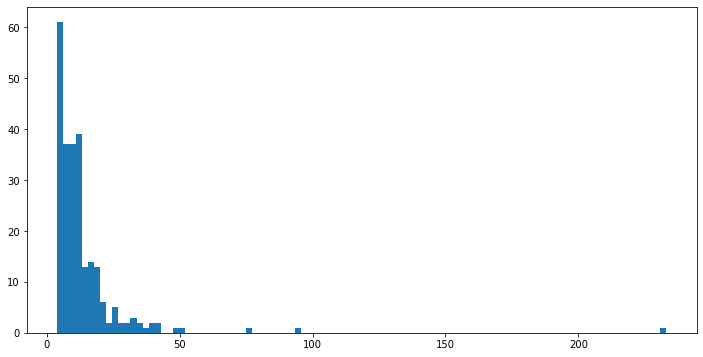

In [78]:

plt.figure(figsize=(12, 6))

# We can also normalize our inputs by the total number of counts
plt.hist(df_dsAll['LENGTH'], bins=100, density=False)


In [13]:
df_dsAll[df_dsAll['length']>=50]

,PDBID,START,END,chain,multi_chain,length
186,1r6z,369,601,A,1,233
219,1v1h,391,467,A,1,77
229,1x86,992,1086,G,1,95
235,2atc,77,126,B,1,50


## DROP vs DS-All

### Separate different PDBID and identical PDBID

In [17]:
df_dsAll.shape[0], df_drop.shape[0]

(246, 212)

In [18]:
len(df_dsAll['PDBID'].unique()), len(df_drop['PDBID'].unique())

(206, 178)

In [19]:
# proteins in DS-All but not in DROP
diffList_dsAll_drop = set(df_dsAll['PDBID']) - set(df_drop['PDBID'])

print(len(diffList_dsAll_drop), set(df_drop['PDBID']) - set(df_dsAll['PDBID']))

# therefore, proteins in DROP is a subset of dsAll. union 
unionList_dsAll_drop = set(df_drop['PDBID'])

28 set()


In [20]:
df_union = df_dsAll[df_dsAll['PDBID'].isin(unionList_dsAll_drop)].sort_values(by=['PDBID', 'START']).reset_index(drop=True)
df_union.shape[0]

212

In [21]:
df_diff = df_dsAll[df_dsAll['PDBID'].isin(diffList_dsAll_drop)].sort_values(by=['PDBID', 'START']).reset_index(drop=True)
df_diff.shape[0]

34

In [22]:
# df_drop[df_drop['multi_chain']==0]

In [23]:
# df_union[~df_union.apply(tuple,1).isin(df_drop.apply(tuple,1))]

In [24]:
# df_drop[~df_drop.apply(tuple,1).isin(df_union.apply(tuple,1))]

### identical PDBID

In [25]:
df_union['LENGTH'].equals(df_drop['LENGTH']), df_union['chain'].equals(df_drop['chain'])

(False, True)

In [26]:
# set index
df_union_i = df_union.set_index(['PDBID',  'multi_chain', 'chain'])
df_drop_i = df_drop.set_index(['PDBID',  'multi_chain', 'chain'])

In [27]:
df_concat = pd.concat([df_union_i, df_drop_i], axis=1)
df_concat.columns = ['START', 'END', 'LENGTH', 'START_d', 'END_d', 'LENGTH_d']
df_concat = df_concat.reset_index()

In [28]:
df_concat[df_concat['multi_chain']==0]

,PDBID,multi_chain,chain,START,END,LENGTH,START_d,END_d,LENGTH_d
3,1a6q,0,0,291,298,8,291,298,8
18,1cfb,0,0,709,720,12,100,111,12
27,1ddt,0,0,377,388,12,377,388,12
44,1eut,0,0,502,505,4,460,463,4
46,1fbr,0,0,45,48,4,45,48,4
49,1fnf,0,0,1233,1239,7,92,98,7
50,1fnf,0,0,1325,1330,6,184,189,6
51,1fnf,0,0,1415,1420,6,274,279,6
64,1grj,0,0,80,90,11,80,90,11
71,1hfh,0,0,63,75,13,63,75,13


In [29]:
df_concat[df_concat['START']!=df_concat['START_d']]

,PDBID,multi_chain,chain,START,END,LENGTH,START_d,END_d,LENGTH_d
0,1a2v,1,A,110,117,8,93,100,8
1,1a2v,1,A,232,242,11,215,225,11
11,1bml,1,D,146,157,12,135,146,12
12,1bml,1,D,278,292,15,267,281,15
13,1c1a,1,B,213,222,10,165,174,10
...,...,...,...,...,...,...,...,...,...
199,1zme,1,C,56,67,12,26,37,12
202,2bb2,0,0,81,88,8,86,93,8
205,2eia,1,A,145,160,16,129,144,16
208,2sli,0,0,272,290,19,192,210,19


In [30]:
df_concat[df_concat['LENGTH']!=df_concat['LENGTH_d']]

,PDBID,multi_chain,chain,START,END,LENGTH,START_d,END_d,LENGTH_d
86,1igt,1,B,223,251,29,215,239,25
87,1igt,1,B,358,367,10,339,347,9
155,1r6z,1,A,369,601,233,371,384,14
187,1v1h,1,A,391,467,77,73,87,15
192,1vj5,1,A,218,231,14,218,233,16


### different PDBID

proteins are abandoned from DROP

In [31]:
df_diff.shape[0], len(df_diff['PDBID'].unique())

(34, 28)

In [32]:
df_diff

,PDBID,START,END,chain,multi_chain,LENGTH
0,1a0p,89,114,0,0,26
1,1au7,74,109,A,1,36
2,1b0n,63,75,A,1,13
3,1bi1,139,149,0,0,11
4,1dvp,136,177,A,1,42
5,1e3h,148,156,A,1,9
6,1e3h,569,605,A,1,37
7,1fo1,188,205,A,1,18
8,1g5i,328,356,C,1,29
9,1gw5,133,171,M,1,39


In [33]:
df_concat[df_concat['PDBID']=='1au7']

,PDBID,multi_chain,chain,START,END,LENGTH,START_d,END_d,LENGTH_d


# Add amino acids information

In [10]:
from Bio import PDB
import os

# Dictionary to map three-letter amino acid codes to one-letter codes
three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'ASX': 'B', 'GLX': 'Z', 'TER': '*', 'UNK': 'X'  # for unknown residues
}

def get_amino_acids_for_region(pdb_id, start, end, chain_id):
    """
    Given a PDB ID, start and end indices (author indices), and chain,
    extract the corresponding amino acids for the region.
    
    Args:
    pdb_id (str): The PDB identifier (e.g., '1a0p').
    start (int): The start index of the region (author index).
    end (int): The end index of the region (author index).
    chain_id (str): The chain identifier (e.g., 'A' or '0').
    
    Returns:
    str: A string of one-letter amino acid codes for the given region.
    """
    
    # URL for downloading the PDB file
    pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    
    # Initialize PDB parser
    parser = PDB.PDBParser(QUIET=True)
    
    # Try downloading the PDB file (if it's not already present)
    pdb_filename = f"{pdb_id}.pdb"
    if not os.path.exists(pdb_filename):
        print(f"Downloading PDB file {pdb_id}...")
        # Download the file
        os.system(f"curl -O {pdb_url}")
    
    # Load the structure from the downloaded PDB file
    structure = parser.get_structure(pdb_id, pdb_filename)
    
    # Retrieve the chain object
    try:
        chain = structure[0][chain_id]
    except KeyError:
        raise ValueError(f"Chain {chain_id} not found in PDB file {pdb_id}.")
    
    # Extract amino acids for the specified region
    amino_acids = []
    
    for res in chain:
        res_id = res.get_id()[1]
        
        # Check if the residue index is within the specified range
        if start <= res_id <= end:
            # Get the three-letter code and convert it to one-letter code
            three_letter_code = res.get_resname()
            one_letter_code = three_to_one.get(three_letter_code, 'X')  # 'X' for unknown
            amino_acids.append(one_letter_code)
    
    # Join the list of amino acids into a string and return
    return ''.join(amino_acids)


In [15]:
df_dsAll = load_tab(path_dsAll_tab)
list_aa = []

for idx, row in df_dsAll.iterrows():
    
    # Example of using the function:
    pdb_id = row['PDBID']
    start = row['START']
    end = row['END']
    chain_id = row['chain']
    try:
        amino_acids = get_amino_acids_for_region(pdb_id, start, end, chain_id)
        list_aa.append(amino_acids)
    except:
        list_aa.append('')
        continue
    print(amino_acids)

ETVQPILT
VGAMRPEAPPI
VDMGPVIDRFELNPT
AEQKRRTTIS
DEKHETLD
RAETPLPLDPTGKVKAE
HKSCFLCMVCKKNLDSTT
GPKGKGKGMGAGTLSTDKGESLGIKYEEGQSHRPTNPNASRMAQKVGGS
HKSCFRCAKCGKSLESTT


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1354k    0 1354k    0     0   699k      0 --:--:--  0:00:01 --:--:--  699k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EPEH


100  851k    0  851k    0     0   537k      0 --:--:--  0:00:01 --:--:--  537k


YGLR
ERLEFGSLLHEFGLLESPKAL


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  173k    0  173k    0     0   152k      0 --:--:--  0:00:01 --:--:--  152k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  763k    0  763k    0     0   482k      0 --:--:--  0:00:01 --:--:--  482k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YKEKPIQNQAKS
KKGEKPYDPFDRSHL


100  305k    0  305k    0     0   223k      0 --:--:--  0:00:01 --:--:--  223k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

WRPTVLTEGP


100 6585k    0 6585k    0     0  2528k      0 --:--:--  0:00:02 --:--:-- 2528k


LMPDMVKNYEDGTTSPGL


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  570k    0  570k    0     0   341k      0 --:--:--  0:00:01 --:--:--  342k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

HPPKDSSGQRVDVSPTSQRLQLLEPFDKWDGKD


100 1587k    0 1587k    0     0   942k      0 --:--:--  0:00:01 --:--:--  942k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LETSVDLITT


100  712k    0  712k    0     0   459k      0 --:--:--  0:00:01 --:--:--  459k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

STYDG


100  217k    0  217k    0     0   140k      0 --:--:--  0:00:01 --:--:--  140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  311k    0  311k    0     0   248k      0 --:--:--  0:00:01 --:--:--  248k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GIKGAFRT


100  345k    0  345k    0     0   242k      0 --:--:--  0:00:01 --:--:--  242k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GDPSLLVRTLVPTEMQ


100  334k    0  334k    0     0   231k      0 --:--:--  0:00:01 --:--:--  230k


KGTIA
ADPIPDAGRS
PVPT


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  271k    0  271k    0     0   200k      0 --:--:--  0:00:01 --:--:--  200k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YTPE


100  185k    0  185k    0     0   164k      0 --:--:--  0:00:01 --:--:--  164k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NWECRYSPKTKRSPLT


100  241k    0  241k    0     0   147k      0 --:--:--  0:00:01 --:--:--  147k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EKTE


100  393k    0  393k    0     0   264k      0 --:--:--  0:00:01 --:--:--  264k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  219k    0  219k    0     0   152k      0 --:--:--  0:00:01 --:--:--  152k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ILEGGSEKADLG


100  190k    0  190k    0     0   131k      0 --:--:--  0:00:01 --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KGHTFPELREMFTADTAPNWADGRVCHRCRVEFTFTNRK


100 1248k    0 1248k    0     0   768k      0 --:--:--  0:00:01 --:--:--  768k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LQXIPLRGCIDDRIPTD


100 1875k    0 1875k    0     0   953k      0 --:--:--  0:00:01 --:--:--  953k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NRKQPITAVSEFPMIGARSIETKPFPAAPARKGLAWHRDS


100  466k    0  466k    0     0   360k      0 --:--:--  0:00:01 --:--:--  360k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AGLPFSGPI
IDTPDEXSPNAPRIIQ


100  574k    0  574k    0     0   361k      0 --:--:--  0:00:01 --:--:--  361k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

QKPTN


100  568k    0  568k    0     0   278k      0 --:--:--  0:00:02 --:--:--  278k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SDYTQNNIHP


100 3818k    0 3818k    0     0  1771k      0 --:--:--  0:00:02 --:--:-- 1771k


TAVTQTYG
TDHTVLVQT


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  729k    0  729k    0     0   433k      0 --:--:--  0:00:01 --:--:--  433k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LQPVCGRX


100  551k    0  551k    0     0   369k      0 --:--:--  0:00:01 --:--:--  369k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TPIEANGKLVPGE


100 1302k    0 1302k    0     0   730k      0 --:--:--  0:00:01 --:--:--  729k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CADNPVSNPC


100  326k    0  326k    0     0   238k      0 --:--:--  0:00:01 --:--:--  238k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DQNDNRP


100  919k    0  919k    0     0   554k      0 --:--:--  0:00:01 --:--:--  553k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AGNVAA


100  403k    0  403k    0     0   224k      0 --:--:--  0:00:01 --:--:--  224k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TKSDRPE


100  880k    0  880k    0     0   492k      0 --:--:--  0:00:01 --:--:--  492k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ERVDVSLPGASLFSGGLH


100  295k    0  295k    0     0   191k      0 --:--:--  0:00:01 --:--:--  191k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SQKGSVGYAD


100  477k    0  477k    0     0   310k      0 --:--:--  0:00:01 --:--:--  310k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

MDDKSENE


100  397k    0  397k    0     0   275k      0 --:--:--  0:00:01 --:--:--  275k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  410k    0  410k    0     0   276k      0 --:--:--  0:00:01 --:--:--  276k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IVEPEPP


100  126k    0  126k    0     0   103k      0 --:--:--  0:00:01 --:--:--  103k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  805k    0  805k    0     0   488k      0 --:--:--  0:00:01 --:--:--  488k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

QQTYQPAKQSFD


100 5214k    0 5214k    0     0  2659k      0 --:--:--  0:00:01 --:--:-- 2657k


KPKGRDSKKV


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  359k    0  359k    0     0   244k      0 --:--:--  0:00:01 --:--:--  244k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  288k    0  288k    0     0   227k      0 --:--:--  0:00:01 --:--:--  227k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SIIIELK


100  264k    0  264k    0     0   205k      0 --:--:--  0:00:01 --:--:--  205k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DTAIRG


100 1805k    0 1805k    0     0   989k      0 --:--:--  0:00:01 --:--:--  989k


HPSILSDIKSVWDRND


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2562k    0 2562k    0     0  1229k      0 --:--:--  0:00:02 --:--:-- 1229k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

PRSEEKKNDRI


100  967k    0  967k    0     0   503k      0 --:--:--  0:00:01 --:--:--  503k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TVQI


100  402k    0  402k    0     0   287k      0 --:--:--  0:00:01 --:--:--  287k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AGAPMPQTMSGPTLGLARFAVSSIPINQQT


100 1171k    0 1171k    0     0   702k      0 --:--:--  0:00:01 --:--:--  702k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FQLRKVLKLHPCLAPIK


100  418k    0  418k    0     0   261k      0 --:--:--  0:00:01 --:--:--  261k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EEDSPA
EAIIKP


100  372k    0  372k    0     0   277k      0 --:--:--  0:00:01 --:--:--  277k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GVVFGRKRKID


100  583k    0  583k    0     0   333k      0 --:--:--  0:00:01 --:--:--  333k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  601k    0  601k    0     0  15.8M      0 --:--:-- --:--:-- --:--:-- 16.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SQPGDEAQPQNL
LIDYLE
SLKETLP
DEMPPGRKEV


100  167k    0  167k    0     0   159k      0 --:--:--  0:00:01 --:--:--  159k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  322k    0  322k    0     0   229k      0 --:--:--  0:00:01 --:--:--  229k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LGLYGKN


100 1115k    0 1115k    0     0   469k      0 --:--:--  0:00:02 --:--:--  469k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ITQQGIKSQIGWRREGIKYRRN


100 1244k    0 1244k    0     0   759k      0 --:--:--  0:00:01 --:--:--  759k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KPGRQYQ


100  466k    0  466k    0     0   273k      0 --:--:--  0:00:01 --:--:--  273k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GGIPEEIP


100  191k    0  191k    0     0   157k      0 --:--:--  0:00:01 --:--:--  157k


LNEEM


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  403k    0  403k    0     0   290k      0 --:--:--  0:00:01 --:--:--  290k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GWLTIQHGKPTKVNNFWETSG


100  573k    0  573k    0     0   397k      0 --:--:--  0:00:01 --:--:--  397k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

VEST


100  157k    0  157k    0     0   130k      0 --:--:--  0:00:01 --:--:--  130k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  142k    0  142k    0     0   105k      0 --:--:--  0:00:01 --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k    0  187k    0     0  4548k      0 --:--:-- --:--:-- --:--:-- 4584k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CRKTNKLSPY


100  154k    0  154k    0     0   106k      0 --:--:--  0:00:01 --:--:--  106k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  531k    0  531k    0     0   392k      0 --:--:--  0:00:01 --:--:--  392k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AKINANI


100  371k    0  371k    0     0   243k      0 --:--:--  0:00:01 --:--:--  243k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NDVQP


100  377k    0  377k    0     0   289k      0 --:--:--  0:00:01 --:--:--  289k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CHYMEQTWA


100  410k    0  410k    0     0   281k      0 --:--:--  0:00:01 --:--:--  281k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IQHTPPQPPEWG


100 1172k    0 1172k    0     0   704k      0 --:--:--  0:00:01 --:--:--  704k


VNKLNHYDY
NPPRATQG


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2382k    0 2382k    0     0  1106k      0 --:--:--  0:00:02 --:--:-- 1107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LITNIGETAGVV


100  420k    0  420k    0     0   289k      0 --:--:--  0:00:01 --:--:--  290k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AAKFSDEIGGHLMSGHIM


100 3882k    0 3882k    0     0  1714k      0 --:--:--  0:00:02 --:--:-- 1714k


NMVEVPLQNGTIPHE


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  219k    0  219k    0     0   169k      0 --:--:--  0:00:01 --:--:--  169k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SPGLERPLKT


100  439k    0  439k    0     0   268k      0 --:--:--  0:00:01 --:--:--  268k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KVLPPSIKRKFS


100 1116k    0 1116k    0     0   611k      0 --:--:--  0:00:01 --:--:--  610k


SSAKTTAP
IEPRGPTIKPCPPCKCPAPNLLGGP
KPKGSVRAP


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  431k    0  431k    0     0   350k      0 --:--:--  0:00:01 --:--:--  350k


CTQPAGVP


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  404k    0  404k    0     0   273k      0 --:--:--  0:00:01 --:--:--  273k


ENEPNL
EENKPTRP


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  207k    0  207k    0     0   136k      0 --:--:--  0:00:01 --:--:--  136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LDNTVEKPWDVKRNRPPKY


100  265k    0  265k    0     0   209k      0 --:--:--  0:00:01 --:--:--  209k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GLDELGLE


100  767k    0  767k    0     0   467k      0 --:--:--  0:00:01 --:--:--  467k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RGDVG


100  950k    0  950k    0     0   612k      0 --:--:--  0:00:01 --:--:--  613k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LFEAP


100  158k    0  158k    0     0   117k      0 --:--:--  0:00:01 --:--:--  117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LAGGKSG


100  968k    0  968k    0     0   585k      0 --:--:--  0:00:01 --:--:--  585k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GVEATGEESSIRQ
KSQFRLPFKSTTP


100  787k    0  787k    0     0   480k      0 --:--:--  0:00:01 --:--:--  480k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DEKNKPRKG


100  283k    0  283k    0     0   279k      0 --:--:--  0:00:01 --:--:--  279k


NHTK


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241k    0  241k    0     0   219k      0 --:--:--  0:00:01 --:--:--  219k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LQEEEEG


100  243k    0  243k    0     0   189k      0 --:--:--  0:00:01 --:--:--  189k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EGGVESGFKHVVPNEV


100  713k    0  713k    0     0   452k      0 --:--:--  0:00:01 --:--:--  452k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SRGRYGLPLSSRPVVKS


100  523k    0  523k    0     0   416k      0 --:--:--  0:00:01 --:--:--  416k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ELKDQRMLS


100  253k    0  253k    0     0   188k      0 --:--:--  0:00:01 --:--:--  188k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EDDHHLPTVQFDFTG


100  921k    0  921k    0     0   566k      0 --:--:--  0:00:01 --:--:--  566k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NDAT


100  345k    0  345k    0     0   272k      0 --:--:--  0:00:01 --:--:--  272k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AFPSD


100  488k    0  488k    0     0   282k      0 --:--:--  0:00:01 --:--:--  282k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

VGPDVLDPNLT
RGQALFRFKVFHRDGEPCERCGSII


100  549k    0  549k    0     0   373k      0 --:--:--  0:00:01 --:--:--  373k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CDKCQLKCSPG


100  212k    0  212k    0     0   162k      0 --:--:--  0:00:01 --:--:--  162k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SESKST


100 1226k    0 1226k    0     0   705k      0 --:--:--  0:00:01 --:--:--  705k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FATV


100 1218k    0 1218k    0     0   682k      0 --:--:--  0:00:01 --:--:--  682k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YHGLPKDPKID


100  195k    0  195k    0     0   164k      0 --:--:--  0:00:01 --:--:--  164k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AQQHGPR


100  342k    0  342k    0     0   245k      0 --:--:--  0:00:01 --:--:--  245k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ADQARTIRIP


100  514k    0  514k    0     0   332k      0 --:--:--  0:00:01 --:--:--  333k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GQVKR
QQSSQNQVDSSSIFNEXSNKGKDQGVVVNNVKTGTPA


100  655k    0  655k    0     0   437k      0 --:--:--  0:00:01 --:--:--  437k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CDFYFG


100  388k    0  388k    0     0   272k      0 --:--:--  0:00:01 --:--:--  272k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

QARAS


100 1093k    0 1093k    0     0   695k      0 --:--:--  0:00:01 --:--:--  695k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IPVQPVYPSAD


100  863k    0  863k    0     0   627k      0 --:--:--  0:00:01 --:--:--  627k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DAAWLD


100  179k    0  179k    0     0   149k      0 --:--:--  0:00:01 --:--:--  149k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

HVHQPVTQPF


100  706k    0  706k    0     0   465k      0 --:--:--  0:00:01 --:--:--  465k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KLYLGYKNKKLRVNINVPMKT


100 1485k    0 1485k    0     0   732k      0 --:--:--  0:00:02 --:--:--  732k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LEFLR


100  257k    0  257k    0     0   248k      0 --:--:--  0:00:01 --:--:--  248k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

HLDD


100  578k    0  578k    0     0   370k      0 --:--:--  0:00:01 --:--:--  370k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SLKTYGVSF


100  982k    0  982k    0     0   664k      0 --:--:--  0:00:01 --:--:--  664k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RILFNG


100  222k    0  222k    0     0   172k      0 --:--:--  0:00:01 --:--:--  172k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LNPEVKKTSWT


100 1123k    0 1123k    0     0   472k      0 --:--:--  0:00:02 --:--:--  472k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NIINFSREP


100 3720k    0 3720k    0     0  1967k      0 --:--:--  0:00:01 --:--:-- 1967k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

MAAPDGTLS


100  271k    0  271k    0     0   213k      0 --:--:--  0:00:01 --:--:--  213k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DYEKY


100  268k    0  268k    0     0   212k      0 --:--:--  0:00:01 --:--:--  212k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DRPFE


100  536k    0  536k    0     0   361k      0 --:--:--  0:00:01 --:--:--  362k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GGLSLQQAPYILP


100  638k    0  638k    0     0   468k      0 --:--:--  0:00:01 --:--:--  468k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DSKAPNASNLK


100  351k    0  351k    0     0   258k      0 --:--:--  0:00:01 --:--:--  258k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

APQHQVQES


100  939k    0  939k    0     0   592k      0 --:--:--  0:00:01 --:--:--  591k


FNPWLNVDSVFMGN
LKPS
LDNPT


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  357k    0  357k    0     0   250k      0 --:--:--  0:00:01 --:--:--  250k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KRKPSGGKPGTYNVWN


100  903k    0  903k    0     0   531k      0 --:--:--  0:00:01 --:--:--  531k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TPGS
RKERD


100  890k    0  890k    0     0   520k      0 --:--:--  0:00:01 --:--:--  520k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

WQPP
YVRDQVKQQYE


100  240k    0  240k    0     0   180k      0 --:--:--  0:00:01 --:--:--  180k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DHVLGVPYTT


100  598k    0  598k    0     0   390k      0 --:--:--  0:00:01 --:--:--  390k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SARKVSSMESPHD
LPKYEGNI


100 1121k    0 1121k    0     0   741k      0 --:--:--  0:00:01 --:--:--  740k


TPGTISDEALLQERQDN
EREQDSIIMD
LNYTCP


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  379k    0  379k    0     0   306k      0 --:--:--  0:00:01 --:--:--  306k


NFESGGAN


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  494k    0  494k    0     0   373k      0 --:--:--  0:00:01 --:--:--  373k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YSVIS
LKKNVSLNA


100  326k    0  326k    0     0   244k      0 --:--:--  0:00:01 --:--:--  245k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TPLYIGRDGCI


100 4752k    0 4752k    0     0  2188k      0 --:--:--  0:00:02 --:--:-- 2189k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DVAESVIPSSGT


100  250k    0  250k    0     0   250k      0 --:--:--  0:00:01 --:--:--  250k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RIHTGQKP
GEKP


100 1345k    0 1345k    0     0   665k      0 --:--:--  0:00:02 --:--:--  665k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SGNS


100  388k    0  388k    0     0   274k      0 --:--:--  0:00:01 --:--:--  274k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ARPRAKI


100  962k    0  962k    0     0   568k      0 --:--:--  0:00:01 --:--:--  568k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

DRREGYPLVEPLGLVKLAPE


100  610k    0  610k    0     0   396k      0 --:--:--  0:00:01 --:--:--  396k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TNPVTGEIPTLSA


100 6255k    0 6255k    0     0  3052k      0 --:--:--  0:00:02 --:--:-- 3054k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  303k    0  303k    0     0   288k      0 --:--:--  0:00:01 --:--:--  288k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

KDYQHLCPKCGVGV


100  327k    0  327k    0     0   230k      0 --:--:--  0:00:01 --:--:--  230k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AQEATQQHGT


100 8417k    0 8417k    0     0  3485k      0 --:--:--  0:00:02 --:--:-- 3485k


VTEG


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5812k    0 5812k    0     0  2114k      0 --:--:--  0:00:02 --:--:-- 2114k


LTPQAV


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  295k    0  295k    0     0   242k      0 --:--:--  0:00:01 --:--:--  242k


EGAN


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  266k    0  266k    0     0   165k      0 --:--:--  0:00:01 --:--:--  165k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YGNSPLHRFKKPGSKNFQNIFPPSA


100 4615k    0 4615k    0     0  2270k      0 --:--:--  0:00:02 --:--:-- 2270k


KEKKAVSPLLLTTTNSSEGLSMGNY


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2428k    0 2428k    0     0  1294k      0 --:--:--  0:00:01 --:--:-- 1293k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

PTGG


100  582k    0  582k    0     0   384k      0 --:--:--  0:00:01 --:--:--  384k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FGGDKEPNVNPTKLP
RILG


100  258k    0  258k    0     0   177k      0 --:--:--  0:00:01 --:--:--  177k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

VLAGSGASLPMLV


100  508k    0  508k    0     0   345k      0 --:--:--  0:00:01 --:--:--  345k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

HGLENFTTN
ARIPEKSVSQS


100  617k    0  617k    0     0   409k      0 --:--:--  0:00:01 --:--:--  409k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AGEDYKAED


100 1006k    0 1006k    0     0   577k      0 --:--:--  0:00:01 --:--:--  577k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AEFVDISHKSFPIS


100  450k    0  450k    0     0   289k      0 --:--:--  0:00:01 --:--:--  289k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

CPDVKYGKR
APDTVIHCEGEPIKREDEEESLNEVG
LSQSNPSALRETVVEVPQVTWEDIGGLEDVKR


100  263k    0  263k    0     0   205k      0 --:--:--  0:00:01 --:--:--  205k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EGRVKKD


100  247k    0  247k    0     0   207k      0 --:--:--  0:00:01 --:--:--  207k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GLPVYNGTPGKP


100  816k    0  816k    0     0   407k      0 --:--:--  0:00:02 --:--:--  408k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

VEAPT


100 2255k    0 2255k    0     0  1254k      0 --:--:--  0:00:01 --:--:-- 1254k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LRSLTRHPKYKTELC


100  205k    0  205k    0     0   168k      0 --:--:--  0:00:01 --:--:--  168k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

XSGPDADIKIGN


100  336k    0  336k    0     0   249k      0 --:--:--  0:00:01 --:--:--  249k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  880k    0  880k    0     0   528k      0 --:--:--  0:00:01 --:--:--  528k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EQVSQQSPYPMPSVKDIS
DKAEEVPDMYGWT


100 1243k    0 1243k    0     0   707k      0 --:--:--  0:00:01 --:--:--  707k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IVRFNRPAV


100  694k    0  694k    0     0   367k      0 --:--:--  0:00:01 --:--:--  367k


VNTPPLVKLWYQLEKEPIVGA


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  400k    0  400k    0     0   287k      0 --:--:--  0:00:01 --:--:--  287k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

MGKKSGKK


100  157k    0  157k    0     0   130k      0 --:--:--  0:00:01 --:--:--  130k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 1097k    0 1097k    0     0   603k      0 --:--:--  0:00:01 --:--:--  602k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

HISES


100  638k    0  638k    0     0   470k      0 --:--:--  0:00:01 --:--:--  470k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RKGTLDKETNMPVDMR
EVNG


100  216k    0  216k    0     0   166k      0 --:--:--  0:00:01 --:--:--  166k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IGESDTDPH


100  627k    0  627k    0     0   425k      0 --:--:--  0:00:01 --:--:--  425k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RVGGAAQI


100  305k    0  305k    0     0   215k      0 --:--:--  0:00:01 --:--:--  215k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 1153k    0 1153k    0     0   691k      0 --:--:--  0:00:01 --:--:--  691k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RLVPMGFVT


100  612k    0  612k    0     0   386k      0 --:--:--  0:00:01 --:--:--  386k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

EPDEDEDV


100 1978k    0 1978k    0     0   916k      0 --:--:--  0:00:02 --:--:--  916k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FPLGAMRLTQRSSNV


100 1140k    0 1140k    0     0   687k      0 --:--:--  0:00:01 --:--:--  687k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FVGGEDHSSEMH


100  504k    0  504k    0     0   330k      0 --:--:--  0:00:01 --:--:--  330k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

ADDHPAA


100  281k    0  281k    0     0   213k      0 --:--:--  0:00:01 --:--:--  213k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GTLNV


100  189k    0  189k    0     0   148k      0 --:--:--  0:00:01 --:--:--  148k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YGTSKRAPRRKALS


100  247k    0  247k    0     0   183k      0 --:--:--  0:00:01 --:--:--  183k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

SPHDHQTHA


100  692k    0  692k    0     0   457k      0 --:--:--  0:00:01 --:--:--  457k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LDAPATSLT
AAGTPLSSPE


100  715k    0  715k    0     0   440k      0 --:--:--  0:00:01 --:--:--  440k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TEVETSNWPTPVPPREIT


100  453k    0  453k    0     0   343k      0 --:--:--  0:00:01 --:--:--  343k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IGGSGYIPEAPRDGQ


100  827k    0  827k    0     0   444k      0 --:--:--  0:00:01 --:--:--  445k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

FPAEE
RTGEERPIRWPETCPECGHRL


100 1371k    0 1371k    0     0   792k      0 --:--:--  0:00:01 --:--:--  792k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IPPSGGAVGGGTTAKDKLGNNVK


100  613k    0  613k    0     0   452k      0 --:--:--  0:00:01 --:--:--  452k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

TNENRELPI


100  374k    0  374k    0     0   266k      0 --:--:--  0:00:01 --:--:--  266k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LTWIEEGQ


100  416k    0  416k    0     0   294k      0 --:--:--  0:00:01 --:--:--  293k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GIQLLNTPAPLPTSCN


100  402k    0  402k    0     0   276k      0 --:--:--  0:00:01 --:--:--  276k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

PSXRP


100 1108k    0 1108k    0     0   671k      0 --:--:--  0:00:01 --:--:--  671k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LQREDLS


100  348k    0  348k    0     0   200k      0 --:--:--  0:00:01 --:--:--  200k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

GSLVSGPSFTSGE


100 1451k    0 1451k    0     0   857k      0 --:--:--  0:00:01 --:--:--  857k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RRLLTKRKMIHEGPLVWDLYTLLLEDILVLLQKQDDRLVVIKLSTVL


100  989k    0  989k    0     0   535k      0 --:--:--  0:00:01 --:--:--  535k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

LGLNRK


100  166k    0  166k    0     0   131k      0 --:--:--  0:00:01 --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  325k    0  325k    0     0   241k      0 --:--:--  0:00:01 --:--:--  241k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  195k    0  195k    0     0  2426k      0 --:--:-- --:--:-- --:--:-- 2449k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

NTQS
SNAICEYLEPSK


100  188k    0  188k    0     0   153k      0 --:--:--  0:00:01 --:--:--  153k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  322k    0  322k    0     0   242k      0 --:--:--  0:00:01 --:--:--  242k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

YAPQATVNRINDYEVVGKSRPSLPERNIDVLVCPDSNCISHAEPVSSSFA


100  162k    0  162k    0     0   134k      0 --:--:--  0:00:01 --:--:--  134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  294k    0  294k    0     0   217k      0 --:--:--  0:00:01 --:--:--  217k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

RADIK
STDKP


100  309k    0  309k    0     0   245k      0 --:--:--  0:00:01 --:--:--  245k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

IGKPKAQNIRQGAKEP


100  251k    0  251k    0     0   195k      0 --:--:--  0:00:01 --:--:--  195k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  499k    0  499k    0     0   328k      0 --:--:--  0:00:01 --:--:--  328k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  477k    0  477k    0     0   318k      0 --:--:--  0:00:01 --:--:--  318k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

VRYS


100  601k    0  601k    0     0   396k      0 --:--:--  0:00:01 --:--:--  396k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

AGERAKQALAFE


  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

GSIRPRAIGGSKPRVAT


100  230k    0  230k    0     0   173k      0 --:--:--  0:00:01 --:--:--  173k


In [20]:
df_dsAll['region'] = list_aa
save_tab(df_dsAll, path_dsAll_tab)

In [19]:
df_dsAll[df_dsAll['region']==''].shape

(24, 7)